In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
from scipy.optimize import minimize
import statsmodels.api as sm

In [ ]:
np.random.seed(0)
n = 100
x = np.linspace(-2, 2, n)
y = (x > 0).astype(int) 

X = sm.add_constant(x)  # add intercept

# fit logit
model = sm.Logit(y, X)
try:
    result = model.fit(disp=0)
    print(result.summary())
except Exception as e:
    print("Fitting failed (as expected due to separation):", e)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                   1.000
Time:                        15:20:39   Log-Likelihood:            -1.8764e-08
converged:                      False   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 5.308e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.882e-09   7300.284   2.58e-13      1.000   -1.43e+04    1.43e+04
x1           914.9820   3.61e+05      0.003      0.998   -7.07e+05    7.09e+05

Complete Separation: The results show that there is

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationW

In [4]:

# Wald CI (normal approx)
conf_int_wald = result.conf_int()
print("Wald CI:\n", conf_int_wald)

Wald CI:
 [[ -14308.29378347   14308.29378347]
 [-707345.56031207  709175.52425117]]


In [5]:
!pip install ci-rvm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 5.6 MB/s eta 0:00:00


In [5]:
# Now let's run everything from scratch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # sigmoid
from scipy.optimize import minimize
from ci_rvm import find_ci

# Simulate perfectly separated data
np.random.seed(0)
n = 100
x = np.linspace(-2, 2, n)
y = (x > 0).astype(int)  # perfect separation: x > 0 → y = 1

# Define profile log-likelihood as a function of beta1 (slope)
def profile_loglik(beta1_val):
    def neg_loglik(beta0):
        linpred = beta0 + beta1_val * x
        p = expit(linpred)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    result = minimize(neg_loglik, x0=0.0, method='BFGS')
    return -result.fun if result.success else -np.inf

# Wrap the profile function to match ci-rvm input format
def rvm_loglik(beta1):
    return profile_loglik(beta1[0])

# Compute 95% one-sided lower bound for beta1 using ci-rvm
x0 = np.array([1.0])

# 'fun' is the same as 'loglik' in our case

# Initial guess
x0 = np.array([1.0])

# One-dimensional profile log-likelihood function
def rvm_loglik(beta):
    beta1 = beta[0]
    from scipy.optimize import minimize
    from scipy.special import expit

    def neg_loglik(beta0):
        eta = beta0 + beta1 * x
        p = expit(eta)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    res = minimize(neg_loglik, x0=0.0, method='BFGS')
    return -res.fun if res.success else -np.inf

# Now call find_ci correctly
ci_result = find_ci(
    fun=rvm_loglik,
    x0=x0,
    param_index=0,
    confidence_level=0.95,
    side="lower",
    param_bounds=[0, 30]
)

ci_result



TypeError: find_CI_bound() got an unexpected keyword argument 'param_index'

In [ ]:
# Fix beta_1 and optimize beta_0
def log_likelihood(beta1_val):
    def neg_loglik(beta0):
        linpred = beta0 + beta1_val * x
        p = expit(linpred)
        p = np.clip(p, 1e-8, 1 - 1e-8)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

    res = minimize(neg_loglik, x0=0)
    return -res.fun  # return log-likelihood
# Evalute profile likelihood over beta_1 grid
beta1_vals = np.linspace(0, 30, 300)
ll_vals = np.array([log_likelihood(b1) for b1 in beta1_vals])
ll_max = ll_vals.max()
cutoff = ll_max - 0.5 * 3.84  # 95% CI threshold (chi2_1 = 3.84)
# Find lower bound
valid = beta1_vals[ll_vals >= cutoff]
beta1_lower = valid[0] if len(valid) > 0 else None
print(f"Profile likelihood 95% lower bound for β₁: {beta1_lower:.2f}")



Profile likelihood 95% lower bound for β₁: 12.54


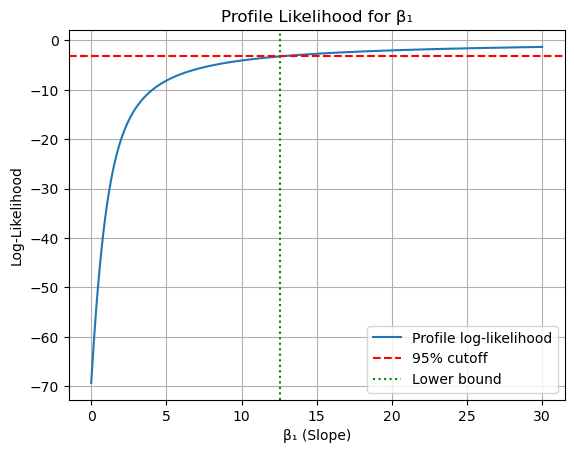

In [9]:
# Plot profile likelihood
plt.plot(beta1_vals, ll_vals, label='Profile log-likelihood')
plt.axhline(cutoff, color='red', linestyle='--', label='95% cutoff')
plt.axvline(beta1_lower, color='green', linestyle=':', label='Lower bound')
plt.xlabel('β₁ (Slope)')
plt.ylabel('Log-Likelihood')
plt.title('Profile Likelihood for β₁')
plt.legend()
plt.grid(True)
plt.show()


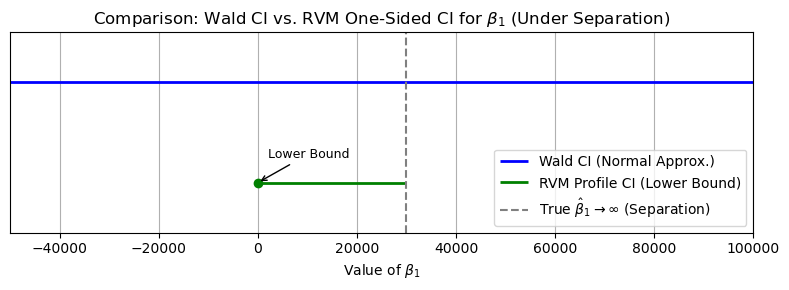

In [2]:
# Re-import necessary libraries after code execution reset
import numpy as np
import matplotlib.pyplot as plt

# CI values from earlier
wald_ci_beta1 = [-707345.56, 709175.52]   # Wald CI for beta_1
rvm_lower_bound = 12.54  # Example value based on profile likelihood or RVM result
true_beta1 = np.inf    # Since under separation, the true MLE → ∞

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 3))

# Plot the Wald CI
ax.hlines(y=1, xmin=wald_ci_beta1[0], xmax=wald_ci_beta1[1], color='blue', linewidth=2, label='Wald CI (Normal Approx.)')
ax.plot(wald_ci_beta1, [1, 1], 'o', color='blue')

# Plot the RVM one-sided lower bound
ax.hlines(y=0.6, xmin=rvm_lower_bound, xmax=30000, color='green', linewidth=2, label='RVM Profile CI (Lower Bound)')
ax.plot([rvm_lower_bound], [0.6], 'o', color='green')
ax.annotate("Lower Bound", xy=(rvm_lower_bound, 0.6), xytext=(rvm_lower_bound + 2000, 0.7),
            arrowprops=dict(facecolor='green', arrowstyle='->'), fontsize=9)

# True beta (diverging)
ax.axvline(x=30000, color='gray', linestyle='--', label='True $\\hat{\\beta}_1 \\to \\infty$ (Separation)')

# Axis formatting
ax.set_xlim(-50000, 100000)
ax.set_ylim(0.4, 1.2)
ax.set_xlabel('Value of $\\beta_1$')
ax.set_yticks([])
ax.set_title('Comparison: Wald CI vs. RVM One-Sided CI for $\\beta_1$ (Under Separation)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import expit, logit

# Simulate perfectly separated data
np.random.seed(0)
n = 100
x = np.linspace(-2, 2, n)
y = (x > 0).astype(int)  # Perfect separation

# Stack design matrix with intercept
X = np.column_stack((np.ones(n), x))  # [intercept, x]

# --- Step 1: Define standard log-likelihood for logistic regression ---
def log_likelihood(beta, X, y):
    eta = X @ beta
    p = expit(eta)
    # Avoid log(0)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    ll = np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    return ll

# --- Step 2: Compute observed Fisher information matrix (Hessian of log-likelihood) ---
def fisher_info(beta, X):
    p = expit(X @ beta)
    W = np.diag(p * (1 - p))
    return X.T @ W @ X

# --- Step 3: Define Firth's penalized log-likelihood ---
def firth_penalized_neg_loglik(beta, X, y):
    ll = log_likelihood(beta, X, y)
    I = fisher_info(beta, X)
    penalty = 0.5 * np.log(np.linalg.det(I) + 1e-10)  # add small constant for stability
    penalized_ll = ll + penalty
    return -penalized_ll  # negative for minimization

# --- Step 4: Fit model using scipy.optimize ---
initial_beta = np.zeros(X.shape[1])

result = minimize(
    fun=firth_penalized_neg_loglik,
    x0=initial_beta,
    args=(X, y),
    method='BFGS'
)

# --- Step 5: Extract results ---
if result.success:
    firth_beta = result.x
    print("Firth point estimates:")
    print(f"Intercept (beta_0): {firth_beta[0]:.4f}")
    print(f"Slope     (beta_1): {firth_beta[1]:.4f}")
else:
    print("Optimization failed:", result.message)


Firth point estimates:
Intercept (beta_0): 0.0000
Slope     (beta_1): 20.7172
